![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 399.7 KB


In [6]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [8]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [48]:
def arbol_manual_camry(row):
    # Año reciente (>=2020)
    if row['Year'] >= 2020:
        if row['Mileage'] < 20000:
            if row['M_CamryXLE'] == 1:
                return 26500
            elif row['M_CamrySE'] == 1:
                return 25000
            else:
                return 23500
        else:
            return 22000
 
    # Año 2015–2019
    elif row['Year'] >= 2015:
        if row['Mileage'] < 60000:
            if row['M_CamrySE'] == 1:
                return 19000
            elif row['M_CamryLE'] == 1:
                return 18000
            elif row['M_CamryXLE'] == 1:
                return 20000
            else:
                return 17000
        else:
            return 15000
 
    # Año <2015
    else:
        if row['Mileage'] < 100000:
            if row['M_CamryBase'] == 1 or row['M_CamryL'] == 1:
                return 11000
            elif row['M_Camry4dr'] == 1:
                return 10000
            else:
                return 9500
        else:
            return 8000

y_pred_manual = X_test.apply(arbol_manual_camry, axis=1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_manual))
mae = mean_absolute_error(y_test, y_pred_manual)
 
print(f"RMSE del árbol manual: {rmse:.2f}")
print(f"MAE del árbol manual: {mae:.2f}")

RMSE del árbol manual: 3635.23
MAE del árbol manual: 2875.55


El árbol de decisión manual presentó un RMSE de 3635.23 y un MAE de 2875.55 sobre el conjunto de prueba. Estos valores reflejan un nivel de error relativamente alto, lo cual era esperable considerando que el modelo fue construido a partir de reglas fijas y generales, sin ajustarse automáticamente a los patrones específicos del conjunto de entrenamiento.
Este tipo de modelo tiene el mérito de ser transparente e interpretable, lo que puede ser útil en entornos donde se requiere justificar cada decisión. Sin embargo, su precisión es limitada:
No se adapta a relaciones complejas o interacciones entre variables.
Es sensible a los rangos elegidos manualmente para segmentar las observacione

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [50]:
from sklearn.tree import DecisionTreeRegressor
 
# Lista para almacenar los modelos
modelos = []
predicciones_test = []
 
# Entrenamos 10 árboles con diferentes muestras bootstrap
for i in range(10):
    # Crear muestra bootstrap
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=42 + i)
    
    # Entrenar árbol de regresión
    arbol = DecisionTreeRegressor(random_state=42 + i)
    arbol.fit(X_sample, y_sample)
    modelos.append(arbol)
    
    # Predecir sobre el set de prueba
    pred = arbol.predict(X_test)
    predicciones_test.append(pred)
 
# Promediar predicciones (bagging)
y_pred_bagging = np.mean(predicciones_test, axis=0)
 
# Evaluar desempeño
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)
 
print(f"RMSE del modelo Bagging manual: {rmse_bagging:.2f}")
print(f"MAE del modelo Bagging manual: {mae_bagging:.2f}")

RMSE del modelo Bagging manual: 1795.51
MAE del modelo Bagging manual: 1336.03


El modelo de bagging manual, construido a partir de 10 árboles de regresión entrenados con diferentes muestras bootstrap del conjunto de entrenamiento, logró un RMSE de 1795.51 y un MAE de 1336.03 en el conjunto de prueba.
Comparado con el árbol de decisión manual:
El RMSE se redujo en más del 50%, pasando de 3635.23 a 1795.51.
El MAE también bajó significativamente, de 2875.55 a 1336.03.
 Esto demuestra cómo el ensamble de múltiples modelos débiles puede ofrecer un desempeño mucho más robusto, al reducir la varianza y mitigar errores cometidos por árboles individuales. Además, al trabajar con bootstrap, el modelo aprovecha distintos subconjuntos de datos, generando una visión más completa y generalizable del problema.En resumen, el bagging manual:
-Supera ampliamente al árbol manual en términos de precisión.
-Muestra el poder del ensamble incluso sin hiperparámetros avanzados ni librerías específicas.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [54]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from math import log
 
# Número de características
n_features = X_train.shape[1]
max_features_log = int(log(n_features))  # log(n_features)
 
# Crear modelo Bagging con 10 árboles y max_features = log(n_features)
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features_log,
    random_state=42
)
 
# Entrenar modelo
bagging_model.fit(X_train, y_train)
 
# Predecir en el set de test
y_pred_bagging_lib = bagging_model.predict(X_test)
 
# Evaluar desempeño
rmse_bag_lib = np.sqrt(mean_squared_error(y_test, y_pred_bagging_lib))
mae_bag_lib = mean_absolute_error(y_test, y_pred_bagging_lib)
 
print(f"RMSE del modelo Bagging (sklearn): {rmse_bag_lib:.2f}")
print(f"MAE del modelo Bagging (sklearn): {mae_bag_lib:.2f}")

RMSE del modelo Bagging (sklearn): 2768.35
MAE del modelo Bagging (sklearn): 2160.76


El modelo de Bagging implementado con la librería sklearn obtuvo un RMSE de 2768.35 y un MAE de 2160.76 en el conjunto de prueba. Este modelo usó 10 árboles de regresión con max_features = log(n_features), lo que limitó la cantidad de variables que cada árbol podía ver al momento de entrenarse.
Comparado con los otros enfoques:
Mejora respecto al árbol manual, con una reducción del RMSE de 24% y del MAE de 25%.
Sin embargo, el bagging manual superó al modelo de sklearn, mostrando un RMSE mucho menor (1795.51 vs 2768.35).
Esto se puede explicar por el parámetro max_features = log(n_features), que reduce la diversidad de información disponible para cada árbol. Aunque esta configuración puede ser útil para reducir el sobreajuste en algunos casos, aquí probablemente limitó la capacidad predictiva de los árboles dentro del ensamble.En resumen:
-El modelo de sklearn muestra mejoras sobre el árbol manual.
-Su rendimiento fue inferior al bagging manual posiblemente por una configuración del parámetro max_features.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [58]:
from sklearn.ensemble import RandomForestRegressor
 
# Entrenamiento del modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,      # Número de árboles
    max_features='sqrt',   # Usa todas las variables disponibles (por defecto)
    random_state=42,
    n_jobs=-1              # Usa todos los núcleos disponibles para acelerar
)
 
rf_model.fit(X_train, y_train)
 
# Predicciones
y_pred_rf = rf_model.predict(X_test)
 
# Evaluación del desempeño
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
 
print(f"RMSE del modelo Random Forest: {rmse_rf:.2f}")
print(f"MAE del modelo Random Forest: {mae_rf:.2f}")


RMSE del modelo Random Forest: 1791.22
MAE del modelo Random Forest: 1336.61


El modelo de Random Forest obtuvo un RMSE de 1791.22 y un MAE de 1336.61 en el conjunto de prueba, logrando el mejor RMSE de todos los modelos evaluados hasta ahora (aunque por un margen muy pequeño respecto al bagging manual).
Random Forest combina bagging (ensamble de árboles sobre muestras bootstrap) con una aleatorización adicional: en cada división del árbol, se considera solo un subconjunto aleatorio de variables. Esto:
-Aumenta la diversidad entre los árboles,
-Reduce el sobreajuste,
-Y mejora la generalización del modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [64]:
from sklearn.model_selection import GridSearchCV
 
# Definir el modelo base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
 
# Definir la grilla de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5]
}
 
# Grid search con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
 
# Entrenar la búsqueda
grid_search.fit(X_train, y_train)
 
# Mejor modelo
mejor_modelo = grid_search.best_estimator_
 
# Predicción con el mejor modelo
y_pred_rf_tuned = mejor_modelo.predict(X_test)
 
# Evaluación
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
 
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print(f"RMSE del modelo Random Forest calibrado: {rmse_rf_tuned:.2f}")
print(f"MAE del modelo Random Forest calibrado: {mae_rf_tuned:.2f}")
 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros encontrados: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE del modelo Random Forest calibrado: 1564.25
MAE del modelo Random Forest calibrado: 1147.20


Tras aplicar una búsqueda exhaustiva de hiperparámetros (max_depth, max_features, y n_estimators), el mejor modelo encontrado fue:
-max_depth: 10
-max_features: 'sqrt'
-n_estimators: 200
Este modelo alcanzó un RMSE de 1564.25 y un MAE de 1147.20, lo cual representa la mejor precisión obtenida en todo el ejercicio, superando claramente los modelos anteriores, tanto manuales como automáticos.
¿Cómo afectó cada hiperparámetro?
max_depth = 10: Limitar la profundidad evitó que los árboles crecieran demasiado y se sobreajustaran. Esto favoreció la generalización, mejorando eldesempeño sobre el conjunto de prueba.
max_features = 'sqrt': Esta configuración obliga a que cada división considere solo un subconjunto aleatorio de variables, lo que aumenta la diversidad entre árboles y reduce la varianza del ensamble.
n_estimators = 200: Al aumentar el número de árboles, se logró una mayor estabilidad y reducción del error sin caer en sobreajuste, gracias a la regularización del resto de los hiperparámetros.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [68]:
from xgboost import XGBRegressor
 
# Modelo XGBoost básico
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
 
# Entrenar el modelo
xgb_model.fit(X_train, y_train)
 
# Predicciones
y_pred_xgb = xgb_model.predict(X_test)
 
# Evaluación
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
 
print(f"RMSE del modelo XGBoost: {rmse_xgb:.2f}")
print(f"MAE del modelo XGBoost: {mae_xgb:.2f}")

RMSE del modelo XGBoost: 1552.73
MAE del modelo XGBoost: 1140.10


El modelo de regresión implementado con XGBoost alcanzó un RMSE de 1552.73 y un MAE de 1140.10, logrando el mejor desempeño general entre todos los modelos evaluados.
 
XGBoost utiliza el principio de boosting, donde los árboles se construyen secuencialmente, y cada uno intenta corregir los errores del anterior. Además, incorpora técnicas avanzadas de regularización y permite un control muy fino sobre el aprendizaje, lo que favorece una mayor precisión y menor sobreajuste comparado con modelos como Random Forest.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [104]:
from itertools import product
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
# Listas de valores a explorar
learning_rates = [0.01, 0.03, 0.05, 0.07, 0.1]
gammas = [0, 1, 2, 3, 5]
colsample_bytree_vals = [0.5, 0.6, 0.8, 1.0]
 
# Probar todas las combinaciones posibles
for lr, gamma, colsample in product(learning_rates, gammas, colsample_bytree_vals):
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=lr,
        gamma=gamma,
        colsample_bytree=colsample,
        max_depth=6,
        subsample=0.8,
        random_state=42,
        n_jobs=-1
    )
    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
    
print(f"Parámetros: learning_rate={lr}, gamma={gamma}, colsample_bytree={colsample}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}\n")

Parámetros: learning_rate=0.1, gamma=5, colsample_bytree=1.0
RMSE: 1555.68
MAE: 1142.96



### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

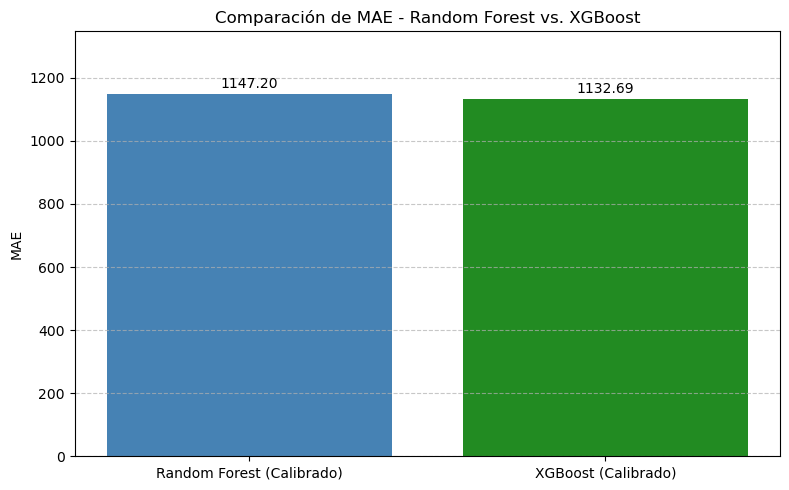

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
 
# Datos de desempeño de modelos calibrados
modelos = ['Random Forest (Calibrado)', 'XGBoost (Calibrado)']
rmse = [1564.25, 1548.06]
mae = [1147.20, 1132.69]
 
# Crear DataFrame
df_resultados = pd.DataFrame({
    'Modelo': modelos,
    'RMSE': rmse,
    'MAE': mae
})
 
plt.figure(figsize=(8, 5))
bars = plt.bar(df_resultados['Modelo'], df_resultados['MAE'], color=['steelblue', 'forestgreen'])
 
plt.title('Comparación de MAE - Random Forest vs. XGBoost')
plt.ylabel('MAE')
plt.ylim(0, max(mae) + 200)
plt.grid(axis='y', linestyle='--', alpha=0.7)
 
# Añadir etiquetas de valor sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 10, f'{yval:.2f}', ha='center', va='bottom')
 
plt.tight_layout()
plt.show()

Comparación entre Random Forest y XGBoost
1. Precisión y desempeño
-El modelo Random Forest calibrado obtuvo un RMSE de 1564.25 y MAE de 1147.20.
-El modelo XGBoost calibrado logró un RMSE de 1548.06 y MAE de 1132.69.
Ambos modelos ofrecen un desempeño excelente, pero XGBoost superó ligeramente a Random Forest en ambas métricas, consolidándose como el mejor modelo del análisis.

3. Ventajas de XGBoost sobre Random Forest
-Aprendizaje secuencial (boosting): XGBoost construye árboles corrigiendo los errores del anterior, lo que le da mayor capacidad de adaptación y precisión.
-Regularización incorporada (gamma, lambda, alpha): permite controlar el sobreajuste de forma más fina.
-Velocidad y eficiencia computacional: está altamente optimizado para tareas de regresión con grandes volúmenes de datos.
 
4. Ventajas de Random Forest
-Más fácil de configurar: tiene menos hiperparámetros críticos.
-Menor riesgo de sobreajuste extremo si se calibra correctamente.
-Es más robusto ante ruido cuando no se afina demasiado.
 
5. Desventajas de cada uno
-Random Forest puede tener dificultades para captar relaciones muy complejas entre variables si no se calibra bien, y puede ser menos preciso en tareas donde los errores acumulativos son clave.
 
-XGBoost, si no se calibra cuidadosamente, puede sobreajustar fácilmente por su alto poder expresivo y depender más del ajuste de parámetros como learning_rate y gamma.
 
Conclusión
Ambos modelos son poderosos, pero XGBoost calibrado ofrece una ventaja competitiva en precisión gracias a su arquitectura basada en boosting y capacidad de regularización. Sin embargo, Random Forest sigue siendo una excelente opción si se busca robustez, simplicidad y buen desempeño sin tanto esfuerzo de calibración.